<center>
<img src="https://habrastorage.org/web/677/8e1/337/6778e1337c3d4b159d7e99df94227cb2.jpg"/>
## Специализация "Машинное обучение и анализ данных"
</center>
<center>Автор материала: программист-исследователь Mail.ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ Юрий Кашницкий

# <center>  Capstone проект №1. Идентификация пользователей по посещенным веб-страницам
<img src='http://i.istockimg.com/file_thumbview_approve/21546327/5/stock-illustration-21546327-identification-de-l-utilisateur.jpg'>

# <center>Неделя 3. Визуальный анализ данных и построение признаков

На 3 неделе мы займемся визуальным анализом данных и построением признаков. Сначала мы вместе построим и проанализируем несколько признаков, потом Вы сможете сами придумать и описать различные признаки. Задание имеет вид Peer-Review, так что творчество здесь активно приветствуется. Если задействуете IPython-виджеты, библиотеку Plotly, анимации и прочий интерактив, всем от этого будет только лучше.

**План 3 недели:**
 - Часть 1. Построение признаков
 - Часть 2. Визуальный анализ данных
 - Часть 3. Дальнейшее построение признаков
 - Часть 4. Проверка построенных признаков

**В этой части проекта Вам могут быть полезны видеозаписи следующих лекций курса "Поиск структуры в данных":**
   - [Задача визуализации](https://www.coursera.org/learn/unsupervised-learning/lecture/hlvlT/zadacha-vizualizatsii)
   - [Визуализация данных в sklearn](https://www.coursera.org/learn/unsupervised-learning/lecture/ityMo/vizualizatsiia-dannykh-v-sklearn)
   
**Также в задании будет использоваться библиотека Seaborn (ее можно дополнительно установить командой *pip install seaborn*), будет полезно обращаться к документациям [Matplotlib](http://matplotlib.org/users/) и [Seaborn](http://seaborn.pydata.org/), а также к примерам визуализации, описанным на StackOverflow.**



## Часть 1. Построение признаков

In [1]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
from glob import glob
import os
from tqdm import tqdm
import numpy as np
import pandas as pd
pd.set_option('display.max.columns', 25)
import pickle
#pip install seaborn
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
# Поменяйте на свой путь к данным
PATH_TO_DATA = './capstone_user_identification/'

**Создайте на основе функций *prepare_train_set* и *prepare_sparse_train_set_window*  новую – *prepare_train_set_with_fe*, (от "feature engineering"), создайте следующие признаки:**
- `session_timespan` – продолжительность сессии (разница между максимальным и минимальным временем посещения сайтов в сессии, в секундах)
- `#unique_sites` – число уникальных сайтов в сессии 
- `start_hour` – час начала сессии (то есть час в записи минимального timestamp среди десяти)
- `day_of_week` – день недели (то есть день недели в записи минимального timestamp среди десяти)

Функция должна возвращать новый DataFrame (как возвращала функция *prepare_train_set*), только признаков должно быть на 4 больше. Порядок, в котором добавляются признаки: *site1*, ... *site10*, *session_timespan*, *#unique_sites*, *start_hour*, *day_of_week* и *user_id* (это видно и чуть ниже по тому, как функция вызывается).

In [53]:
def prepare_train_set_with_fe(path_to_csv_files, site_freq_path, feature_names,
                                    session_length=10, window_size=10):
    def get_user_id(filename):
        pos=(filename.find('.csv'))
        return int(filename[pos-4:pos])
    def get_site_id(site):
        return unique_dictionary[site][0]
    def get_dictionary(path_to_csv_files, site_freq_path):
        if os.path.exists(PATH_TO_DATA+site_freq_path):
            with open(PATH_TO_DATA+site_freq_path, 'rb') as X_pkl:
                unique_dictionary=pickle.load(X_pkl)
        else:
            unique_dictionary = pd.DataFrame(columns = ['site', 'frequency'])
            sites = pd.DataFrame(columns = ['site'])
            for i in sorted(glob(PATH_TO_DATA+path_to_csv_files+'/user****.csv')):
                inf = pd.read_csv(i,header = 0)
                sites = pd.concat([sites,inf], ignore_index=True, join="inner") 
            sites['frequency'] = sites.groupby('site')['site'].transform('count')
            unique_dictionary=pd.concat([unique_dictionary,sites[['site', 'frequency']].drop_duplicates()], 
                                            ignore_index=True)
            sites = 0
            unique_dictionary.drop_duplicates()
            unique_dictionary.sort_values(by='frequency',ascending=False, inplace = True, ignore_index=True)
            unique_dictionary['site_id'] = unique_dictionary.index+1
            unique_dictionary['site_freq']=unique_dictionary.apply(lambda row: [row['site_id'],row['frequency']], 
                                                                   axis=1)
            unique_dictionary.set_index(unique_dictionary.site,inplace=True)
            unique_dictionary = unique_dictionary.site_freq.to_dict()
            with open(os.path.join(PATH_TO_DATA, 
                           'site_freq_{}.pkl'.format(path_to_csv_files)), 'wb') as site_freq_pkl:
                pickle.dump(unique_dictionary, site_freq_pkl, protocol=2)
        return unique_dictionary
    def sessions(data):
        length = len(data)
        start = 0
        Loop = True
        while Loop:
            if start<=length-session_length:
                #print('Start', start,'End', start+session_length,'more to go', length-start-session_length)
                #print([get_site_id(j) for j in data.site.iloc[start:start+session_length].to_list()])
                # site ids
                session = [get_site_id(j) for j in data.site.iloc[start:start+session_length].to_list()]
                # one site duration
                if r'time_diff1' in feature_names:
                    session += [(data.timestamp.iloc[i+1]-data.timestamp.iloc[i])/pd.Timedelta(seconds=1) for i in 
                            range(start,start+session_length-1)]
                # session duration
                session += [(data.timestamp.iloc[start+session_length-1]-
                             data.timestamp.iloc[start])/pd.Timedelta(seconds=1)]
                # #unique_ids
                session += [len(np.unique(session[:session_length]))]
                # start hour
                session += [data.timestamp.iloc[start].hour]
                # start weekday
                session += [data.timestamp.iloc[start].weekday()]
            else:
                # site ids
                session = [get_site_id(j) for j in data.site.iloc[start:length+1]]
                session +=[0 for i in range(session_length-(len(data)-start))]
                if sum(session) == 0:
                    Loop = False
                    continue
                # one site duration
                if 'time_diff1' in feature_names:
                    session +=[(data.timestamp.iloc[i+1]-data.timestamp.iloc[i])/pd.Timedelta(seconds=1) for i in 
                                range(start,length-1)]
                    session +=[0 for i in range(session_length-(len(data)-start))]
                # session duration
                session += [(data.timestamp.iloc[length-1]-
                             data.timestamp.iloc[start])/pd.Timedelta(seconds=1)]
                
                # #unique_ids
                session += [len(np.unique(session[:session_length]))-1]
                # start hour
                session += [data.timestamp.iloc[start].hour]
                # start weekday
                session += [data.timestamp.iloc[start].weekday()]
            if sum(session) == 0:
                Loop = False
            start+=window_size
            if sum(session)>0:
                session+=[user_id]
                session = np.array(session, dtype = 'int64')
                #print(session)
                df_sessions.loc[len(df_sessions)] = session
                #pd.concat([df_sessions, pd.Series(session)], axis=0, ignore_index = True)
                #print('len df_sessions', len(df_sessions))
    def convert_to_sparse(ar):
        def tokenizer(s):
            return list(s)
        vectorizer = CountVectorizer(analyzer=tokenizer)
        X = vectorizer.fit_transform(ar)
        X=X[:,1:]
        return X

    ### MAIN ###
    cols=['site'+str(col_name) for col_name in range(1,session_length+1)]
    cols.append('user_id')
    df_sessions = pd.DataFrame(columns = feature_names)
    unique_dictionary = get_dictionary(path_to_csv_files, site_freq_path)
    for i in tqdm(sorted(glob(PATH_TO_DATA+path_to_csv_files+'/user****.csv'))):
        inf = pd.read_csv(i, header = 0)
        inf.timestamp = pd.to_datetime(inf.timestamp)
        user_id = get_user_id(i)
        #print('User ID:', user_id)
        sessions(inf)
        d1 = 0
        inf = 0
    #print(df_sessions)
    X_train, y_train = df_sessions.iloc[:, :-1].values, df_sessions.iloc[:, -1].values
    with open(os.path.join(PATH_TO_DATA, 
                       'X_sparse_{}_s{}_w{}.pkl'.format(path_to_csv_files,session_length,window_size)),
              'wb') as X_pkl:
        pickle.dump(convert_to_sparse(X_train), X_pkl, protocol=2)
    with open(os.path.join(PATH_TO_DATA, 
                           'y_{}_s{}_w{}.pkl'.format(path_to_csv_files,session_length,window_size)), 
              'wb') as y_pkl:
        pickle.dump(y_train, y_pkl, protocol=2)
    return df_sessions

**Проверим функцию на игрушечном примере.**

In [63]:
#feature_names = ['site' + str(i) for i in range(1,11)] + \
                #['time_diff' + str(j) for j in range(1,10)] + \
                #['session_timespan', '#unique_sites', 'start_hour','day_of_week', 'target']
feature_names = ['site' + str(i) for i in range(1,11)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 'day_of_week', 'target']
train_data_toy  = prepare_train_set_with_fe('3users','site_freq_3users.pkl',
                  feature_names=feature_names, session_length=10)

100%|██████████| 3/3 [00:00<00:00, 84.29it/s]


In [64]:
train_data_toy

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,session_timespan,#unique_sites,start_hour,day_of_week,target
0,3,2,2,7,2,1,8,5,9,10,7998,8,9,4,1
1,3,1,1,1,0,0,0,0,0,0,60,2,12,4,1
2,3,2,6,6,2,0,0,0,0,0,7935,3,9,4,2
3,4,1,2,1,2,1,1,5,11,4,7998,5,9,4,3
4,4,1,2,0,0,0,0,0,0,0,1471,3,12,4,3


**Примените функцию *prepare_train_set_with_fe* к данным по 10 пользователям, укажите *session_length*=10.**

In [96]:
%%time
feature_names = ['site' + str(i) for i in range(1,11)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week', 'target']
train_data_10users = prepare_train_set_with_fe('10users','site_freq_10users.pkl',
                  feature_names=feature_names, session_length=10)

100%|██████████| 10/10 [00:44<00:00,  4.41s/it]

CPU times: user 44.3 s, sys: 7.62 ms, total: 44.3 s
Wall time: 44.2 s


In [102]:
train_data_10users.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,session_timespan,#unique_sites,start_hour,day_of_week,target
0,192,577,133,3,133,133,3,133,203,133,33,5,8,4,31
1,423,193,679,255,133,31,393,3552,220,55,284,10,8,4,31
2,55,3,55,55,5,295,423,338,901,55,258,7,8,4,31
3,481,3398,481,55,55,55,55,946,201,124,30,6,8,4,31
4,349,55,5,3634,259,211,3643,2169,689,2169,6,9,8,4,31


**Примените функцию *prepare_train_set_with_fe* к данным по 150 пользователям, укажите *session_length*=10.**

In [67]:
%%time
train_data_150users = prepare_train_set_with_fe('150users','site_freq_150users.pkl',
                  feature_names=feature_names, session_length=10)

100%|██████████| 150/150 [41:44<00:00, 16.69s/it]


CPU times: user 37min 58s, sys: 3min 46s, total: 41min 45s
Wall time: 41min 45s


**Сохраните в pickle-файлы признаки *session_timespan*, *#unique_sites*, *start_hour* и *day_of_week* для 10 и 150 пользователей.**

In [74]:
new_features_10users = train_data_10users.loc[:,['session_timespan', '#unique_sites', 'start_hour', 'day_of_week']]
new_features_150users = train_data_150users.loc[:,['session_timespan', '#unique_sites', 'start_hour', 'day_of_week']]

In [75]:
with open(os.path.join(PATH_TO_DATA, 
                       'new_features_10users.pkl'), 'wb') as new_features_10users_pkl:
    pickle.dump(new_features_10users, new_features_10users_pkl)
with open(os.path.join(PATH_TO_DATA, 
                       'new_features_150users.pkl'), 'wb') as new_features_150users_pkl:
    pickle.dump(new_features_150users, new_features_150users_pkl)

## Часть 2. Визуальный анализ данных

**Забавы ради, для потехи дадим пользователям имена и ассоциируем с ними цвета.**

In [3]:
id_name_dict = {128: 'Mary-Kate', 39: 'Ashley', 207: 'Lindsey', 127: 'Naomi', 237: 'Avril',
               33: 'Bob', 50: 'Bill', 31: 'John', 100: 'Dick', 241: 'Ed'}
#train_data_10users['target'] = train_data_10users['target'].map(id_name_dict)

In [4]:
color_dict = {'Mary-Kate': 'pink', 'Ashley': 'darkviolet', 'Lindsey':'blueviolet', 
             'Naomi': 'hotpink', 'Avril': 'orchid', 
             'Bob': 'firebrick', 'Bill': 'gold', 'John': 'forestgreen', 
             'Dick': 'slategrey', 'Ed':'brown'}

**1. Постройте гистограмму распределения длины сессии в секундах (*session_timespan*). Ограничьте по *x* значением 200 (иначе слишком тяжелый хвост). Сделайте гистограмму цвета *darkviolet*, подпишите оси по-русски.**

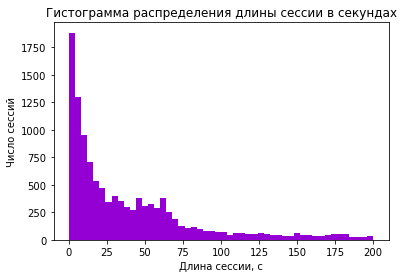

In [81]:
plt.title('Гистограмма распределения длины сессии в секундах')
plt.xlabel('Длина сессии, с')
plt.ylabel('Число сессий')
plt.hist(train_data_10users['session_timespan'], bins=50, range=(0,200), color='darkviolet')
plt.show()

**2. Постройте гистограмму распределения числа уникальных сайтов в сессии (*#unique_sites*). Сделайте гистограмму цвета *aqua*, подпишите оси по-русски.**

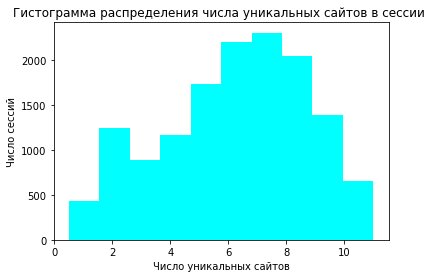

In [86]:
plt.title('Гистограмма распределения числа уникальных сайтов в сессии ')
plt.xlabel('Число уникальных сайтов')
plt.ylabel('Число сессий')
plt.hist(train_data_10users['#unique_sites'], bins=10, range=(0.5,11), color='aqua')
plt.show()

**3. Постройте гистограммы распределения числа уникальных сайтов в сессии (*#unique_sites*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

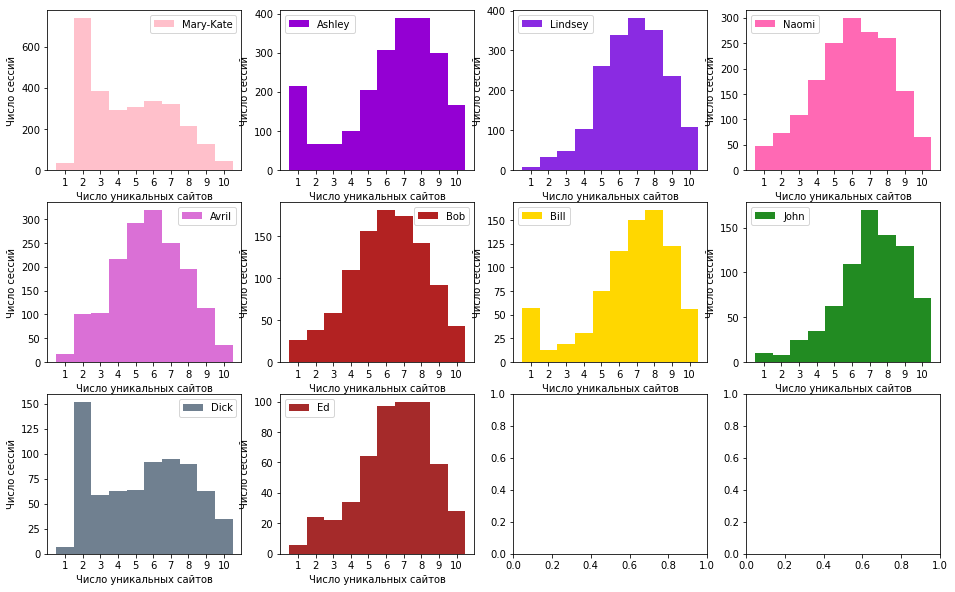

In [110]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

# как вариант, можно и по-другому
idx = 0
for key in id_name_dict.keys():
    name=id_name_dict[key]
    ax=axes.ravel()[idx]
    user_data = train_data_10users[train_data_10users.target == key]
    ax.set_xlabel('Число уникальных сайтов') 
    ax.set_ylabel('Число сессий')
    ax.set_xticks(range(1,11))
    ax.hist(user_data['#unique_sites']  , bins=10, range=(0.5,10.5),align='mid' ,label=name , 
            color=color_dict[name])
    ax.legend(loc='best')
    idx+=1
plt.show()

**4. Постройте гистограмму распределения часа начала сессии (*start_hour*). Сделайте гистограмму цвета *darkgreen*, подпишите оси по-русски.**

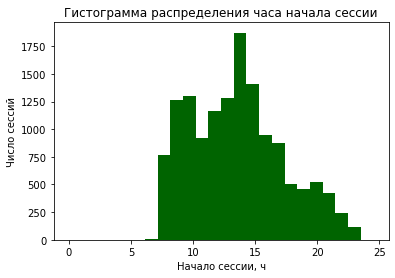

In [113]:
plt.title('Гистограмма распределения часа начала сессии')
plt.xlabel('Начало сессии, ч')
plt.ylabel('Число сессий')
plt.hist(train_data_10users['start_hour'], bins=24, range=(0,24.5), color='darkgreen')
plt.show()

**5. Постройте гистограммы распределения часа начала сессии (*start_hour*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

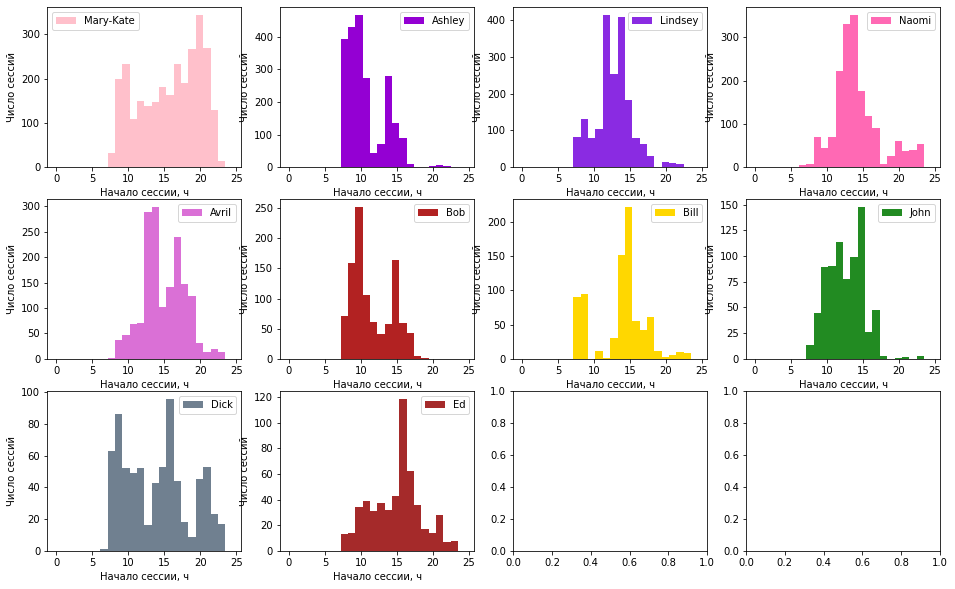

In [117]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

# как вариант, можно и по-другому
idx = 0
for key in id_name_dict.keys():
    name=id_name_dict[key]
    ax=axes.ravel()[idx]
    user_data = train_data_10users[train_data_10users.target == key]
    ax.set_xlabel('Начало сессии, ч') 
    ax.set_ylabel('Число сессий')
    ax.hist(user_data['start_hour'], bins=24, range=(0,24.5),align='mid' ,label=name , 
            color=color_dict[name])
    ax.legend(loc='best')
    idx+=1
plt.show()

**6. Постройте гистограмму распределения дня недели, в который началась сессия (*day_of_week*). Сделайте гистограмму цвета *sienna*, подпишите оси по-русски.**

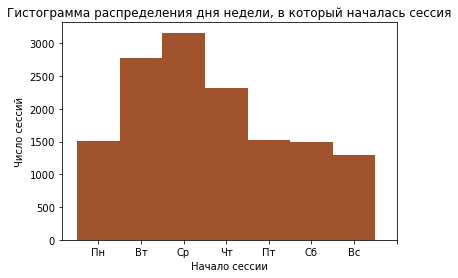

In [127]:
plt.title('Гистограмма распределения дня недели, в который началась сессия')
plt.xlabel('Начало сессии')
plt.ylabel('Число сессий')
plt.hist(train_data_10users['day_of_week'], bins=7, range=(-0.5,6.5), color='sienna')
plt.xticks(range(8),['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'])
plt.show()

**7. Постройте гистограммы распределения дня недели, в который началась сессия (*day_of_week*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Измените метки по оси *X* на ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'] – метод *set_xticklabels*. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите по-русски название каждой из 10 гистограмм.**

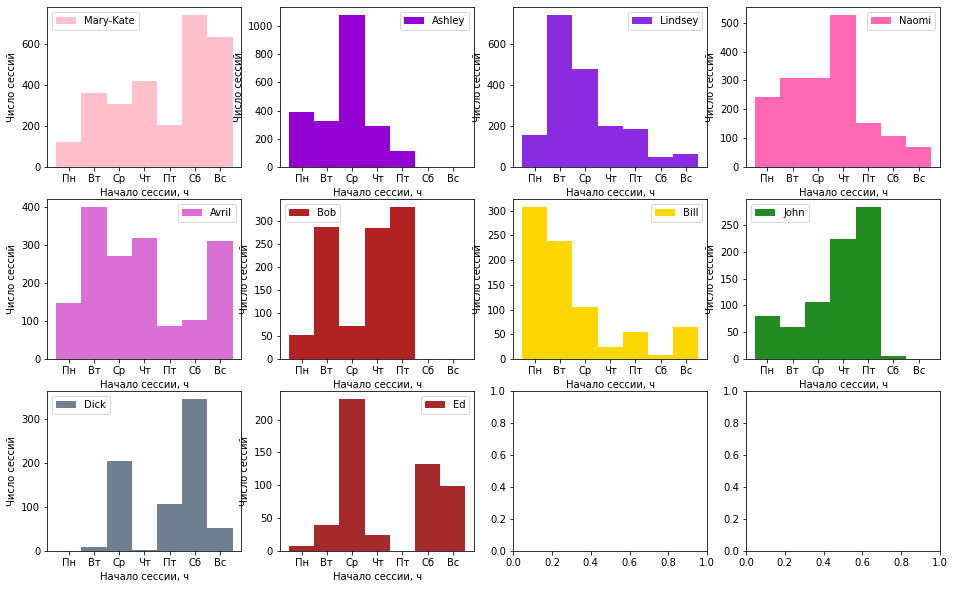

In [132]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

# как вариант, можно и по-другому
idx = 0
for key in id_name_dict.keys():
    name=id_name_dict[key]
    ax=axes.ravel()[idx]
    user_data = train_data_10users[train_data_10users.target == key]
    ax.set_xlabel('Начало сессии, ч') 
    ax.set_ylabel('Число сессий')
    ax.hist(user_data['day_of_week'], bins=7, range=(-0.5,6.5),align='mid' ,label=name , 
            color=color_dict[name])
    ax.set_xticks(range(7))
    ax.set_xticklabels(['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'])
    ax.legend(loc='best')
    idx+=1
plt.show()

**8. Сделайте выводы про каждого пользователя по построенным графикам.**

* Mary-Kate: Сидит в интернете по выходным, в основном - утром и вечером, в нерабочие часы. Число уникальных сайтов редко превышает 2 - видимо сидит в соцсеитях после работы.
* Ashley: Совсем не пользуется интернетом в выходные. Начало сессии приходится на рабочие часы. Много сессий с большим количеством уникальных сайтов - использует интернет для работы.
* Lindsey: Пик активности приходится на вторник - чаще сидит в интернете в рабочие дни, чем в выходные, время начала сессий - в основном рабочее, лишь немного после 19:00. Много уникальных сайтов
* Naomi: Основная активность в рабочие дни и часы, небольшая активность в вечерние часы. Обычное распределение уникальных сайтов
* Avril: Основная активность в рабочие дни и воскресенье. Медиана числа уникальных сайтов немного смещена относительно обычного распределения в меньшую сторону.
* Bob: Отсутствует активность в выходные дни, пики активности - вт, чт и пт. Отсутствие активности в нерабочие часы. Обычное распределение числа уникальных сайтов.
* Bill: Основная активность: пн, вт и ср, во второй половине дня. В распределении количества уникальных сайтов выделяется большее, чем обычно количество сессий с 1 уникальным сайтом.
* John: Активность только в рабочие дни и в основном в рабочее время. Преобладают сессии с большим количеством уникальных сайтов
* Dick: основная активность в выходные дни. В распределении времени начала сессии явно присутствуют перерывы на обед и ужин. Распределение числа уникальных сайтов схоже с таковым у Mary-Kate - преобладают сессии с 2 уникальными сайтами.
* Ed: Основная активность в среду, высокая активность в выходные дни. Пик активности приходится на приблизительно 16 часов. Больше всего сессий с 6-8 уникальными сайтами.

**Загрузите сохраненный ранее в pickle-файл частотный словарь сайтов для 10 пользователей. **

In [133]:
with open(PATH_TO_DATA+'site_freq_10users.pkl', 'rb') as X_pkl:
    site_freq_10users=pickle.load(X_pkl)

**Определите топ-10 самых посещаемых сайтов (*top10_sites*) и соответствующие кол-ва посещений (*top10_freqs*).**

In [146]:
top10_freqs = pd.DataFrame(site_freq_10users).T.iloc[:10].index.to_list()
top10_sites = pd.DataFrame(site_freq_10users).T.iloc[:10,1].to_list()

**9. Нарисуйте *seaborn barplot*, показывающий частоты посещений топ-10 сайтов. Сделайте подписи сайтов вертикальными, иначе они сливаются (*xticks*).**

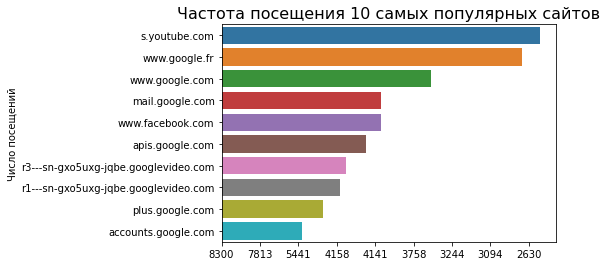

In [149]:
ax=sns.barplot(x=top10_sites,y=top10_freqs)
ax.set_title('Частота посещения 10 самых популярных сайтов',size=16)
ax.set_ylabel('Число посещений')
ax.set_xticklabels(top10_sites)
plt.show()

## Часть 3. Проверка построенных признаков
Эта часть скорее техническая, смысл ее – убедиться, что мы все одинаково создали признаки *session_timespan, #unique_sites, start_hour* и *day_of_week*.

**10. Выведите медианную продолжительность сессии (*session_timespan*) для сессий 10 пользователей.**

In [150]:
np.median(train_data_10users['session_timespan'])

37.0

**11. Выведите медианный день недели, в который началась сессия, для сессий 10 пользователей.**

In [151]:
np.median(train_data_10users['day_of_week'])

2.0

**12. Выведите медианный час начала сессии для сессий 150 пользователей.**

In [152]:
np.median(train_data_10users['start_hour'])

14.0

**13. Выведите медианное значение числа уникальных сайтов в сессиях 150 пользователей.**

In [153]:
np.median(train_data_10users['#unique_sites'])

6.0

## Часть 4. Дальнейшее построение признаков

Это задание творческое, тут надо придумать, как еще учесть время посещения веб-страниц и прочие признаки. 

На следующей неделе мы будем использовать "мешок" сайтов  для классификации сессий по принадлежности разным пользователям, а эти новые признаки, которые Вы сейчас создадите, потом добавим и посмотрим, улучшается ли модель. Поэтому можно их создать в виде отдельных матриц и сохранить их также отдельно.  

В этой части задания Вы можете построить и визуально исследовать самые разные признаки (ничто фантазию не ограничивает):
- год, месяц и день начала сессии
- час начала сессии (с учетом года, месяца и дня)
- время суток
- среднее время пребывания на сайте, посчитать можно, скажем, для топ-30 популярных сайтов
- индикаторы посещения популярных сайтов (скажем, тоже для топ-30 популярных сайтов)
- частота посещения Facebook
- ...

**Напишите функцию для создания новых признаков и примените ее к исходным данным – каталогам с 10 и 150 файлами. Сделайте это только для набора данных, полученного с параметрами *session_length=10* и *window_size=10*. Сериализуйте полученные матрицы с помощью pickle. Функция может возвращать как только новые признаки, так и старые с новыми. При этом сигнатура функции может быть другой – тут уже свобода выбора.**

Признаки:
* Доля времени посещения сайта из топ-10 от общего времени сессии
* Количество сайтов из топ-30 в сессии
* Доля общего времени, проведенного на сайтах из топ-30

In [5]:
def feature_engineering(path_to_csv_files, site_freq_path, features, session_length=10, window_size=10):
    def get_user_id(filename):
        pos=(filename.find('.csv'))
        return int(filename[pos-4:pos])
    def get_site_id(site):
        if site in unique_dictionary.keys():
            return unique_dictionary[site][0]
        else:
            return 0
    def sessions(data):
        length = len(data)
        start = 0
        Loop = True
        top10 = pd.DataFrame(unique_dictionary).T.iloc[:10].index.to_list()
        #top30 = pd.DataFrame(unique_dictionary).T.iloc[:30].index.to_list()
        while Loop:
            if start<=length-session_length:
                #print('Start', start,'End', start+session_length,'more to go', length-start-session_length)
                #print([get_site_id(j) for j in data.site.iloc[start:start+session_length].to_list()])
                sessiondf = data.iloc[start:start+session_length]
                sessiondf['tdelta'] = np.array([0 for i in range(10)])
                for i in range(session_length-1):
                    sessiondf.tdelta.iloc[i] = (sessiondf.timestamp.iloc[i+1]-
                                                sessiondf.timestamp.iloc[i])/pd.Timedelta(seconds=1)
                #print(sessiondf)
            else:
                sessiondf = data.iloc[start:length+1]
                sessiondf = pd.concat([sessiondf,pd.DataFrame([['1991-01-01 00:00:00',0] for i in range(session_length-(len(data)-start))],
                                                              columns = ['timestamp','site'])],ignore_index=True)
                sessiondf.timestamp = pd.to_datetime(sessiondf.timestamp)
                #print(sessiondf)
                if len(sessiondf.site[sessiondf.site != 0]) == 0:
                    Loop = False
                    continue
                sessiondf['tdelta'] = np.array([0 for i in range(10)])
                for i in range(session_length-1):
                    sessiondf.tdelta.iloc[i] = (sessiondf.timestamp.iloc[i+1]-
                                                sessiondf.timestamp.iloc[i])/pd.Timedelta(seconds=1)
                    sessiondf.tdelta[sessiondf.tdelta<0] = 0
            #print("Hallelujah, it was processed!")
            #print(sessiondf)
            # site ids
            session = [get_site_id(j) for j in sessiondf.site.to_list()]
            # one site duration
            if 'time_diff1' in feature_names:
                    session += [j for j in sessiondf.tdelta.iloc[:-1]]
            # session duration
            s_end_time = sessiondf.timestamp[sessiondf.timestamp > '1991-01-01 00:00:00'].iloc[-1]
            sduration = (s_end_time-sessiondf.timestamp.iloc[0])/pd.Timedelta(seconds=1)
            session += [sduration]
            # #unique_ids
            session += [len(np.unique(sessiondf.site[sessiondf.site !=0]))]
            # start hour
            session += [sessiondf.timestamp.iloc[0].hour]
            # start weekday
            session += [sessiondf.timestamp.iloc[0].weekday()]
            # Доля времени посещения сайта из топ-10 от общего времени сессии
            if sduration != 0:
                for i in top10:
                    if i in sessiondf.site.to_list():
                        session += [sessiondf.tdelta[sessiondf.site == i].sum()/sduration]
                    else:
                        session += [0]
            else:
                session += [0 for i in range(10)]
            # Количество сайтов из топ-10 в сессии
            scount = 0
            for i in top10:
                if i in sessiondf.site.to_list():
                    scount+=1
            session += [scount]
            # Доля общего времени, проведенного на сайтах из топ-10
            if sduration != 0:
                s10time = 0
                for i in top10:
                    if i in sessiondf.site.to_list():
                        s10time += sessiondf.tdelta[sessiondf.site == i].sum()
                session += [s10time/sduration]
            else:
                session += [0]
            session+=[user_id]
            session = np.array(session, dtype = 'float64')
            session = np.round_(session, decimals = 2)
            #print(session)
            df_sessions.loc[len(df_sessions)] = session
            #pd.concat([df_sessions, pd.Series(session)], axis=0, ignore_index = True)
            #print('len df_sessions', len(df_sessions))
            start+=window_size
    def convert_to_sparse(ar):
        def tokenizer(s):
            return list(s)
        vectorizer = CountVectorizer(analyzer=tokenizer)
        X = vectorizer.fit_transform(ar)
        X=X[:,1:]
        return X

    ### MAIN ###
    cols=['site'+str(col_name) for col_name in range(1,session_length+1)]
    cols.append('user_id')
    df_sessions = pd.DataFrame(columns = feature_names)
    with open(PATH_TO_DATA+site_freq_path, 'rb') as X_pkl:
                unique_dictionary=pickle.load(X_pkl)
    for i in tqdm(sorted(glob(PATH_TO_DATA+path_to_csv_files+'/user****.csv'))):
        inf = pd.read_csv(i, header = 0)
        inf.timestamp = pd.to_datetime(inf.timestamp)
        user_id = get_user_id(i)
        #print('User ID:', user_id)
        sessions(inf)
        d1 = 0
        inf = 0
    #print(df_sessions)
    return df_sessions 

In [6]:
#feature_names = ['site' + str(i) for i in range(1,11)] + \
                #['time_diff' + str(j) for j in range(1,10)] + \
                #['session_timespan', '#unique_sites', 'start_hour','day_of_week', 'target']
feature_names = ['site' + str(i) for i in range(1,11)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 'day_of_week'] + \
                ['top{}_t_p'.format(i)for i in range(1,11)] + \
                ['num_top30','time_percent_top30', 'target']
train_data_toy  = feature_engineering('3users','site_freq_3users.pkl',
                  features=feature_names, session_length=10)

100%|██████████| 3/3 [00:00<00:00, 18.45it/s]


In [7]:
train_data_toy

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,session_timespan,#unique_sites,...,top2_t_p,top3_t_p,top4_t_p,top5_t_p,top6_t_p,top7_t_p,top8_t_p,top9_t_p,top10_t_p,num_top30,time_percent_top30,target
0,3.0,2.0,2.0,7.0,2.0,1.0,8.0,5.0,9.0,10.0,7998.0,8.0,...,0.93,0.04,0.00,0.0,0.00,0.02,0.0,0.01,0.0,8.0,1.00,1.0
1,3.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,60.0,2.0,...,0.00,0.03,0.00,0.0,0.00,0.00,0.0,0.00,0.0,2.0,1.00,1.0
2,3.0,2.0,6.0,6.0,2.0,0.0,0.0,0.0,0.0,0.0,7935.0,3.0,...,0.15,0.04,0.00,0.0,0.81,0.00,0.0,0.00,0.0,3.0,1.00,2.0
3,4.0,1.0,2.0,1.0,2.0,1.0,1.0,5.0,11.0,4.0,7998.0,5.0,...,0.79,0.00,0.04,0.0,0.00,0.00,0.0,0.00,0.0,4.0,0.99,3.0
4,4.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1471.0,3.0,...,0.00,0.00,0.20,0.0,0.00,0.00,0.0,0.00,0.0,3.0,1.00,3.0


In [8]:
new_features_10users = feature_engineering('10users','site_freq_10users.pkl',
                  features=feature_names, session_length=10)

100%|██████████| 10/10 [02:19<00:00, 13.94s/it]


In [9]:
new_features_150users = feature_engineering('150users','site_freq_150users.pkl',
                  features=feature_names, session_length=10)

100%|██████████| 150/150 [37:36<00:00, 15.04s/it]


**14. Постройте картинки для новых признаков, поисследуйте их, прокомментируйте результаты.**

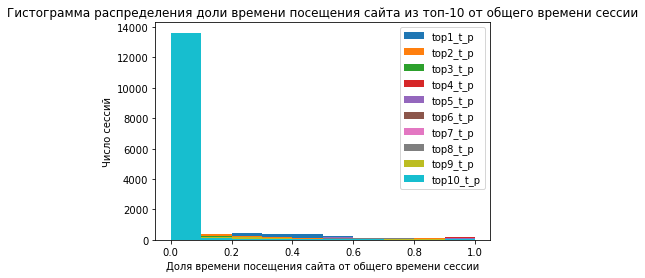

In [16]:
plt.title('Гистограмма распределения доли времени посещения сайта из топ-10 от общего времени сессии')
plt.xlabel('Доля времени посещения сайта от общего времени сессии')
plt.ylabel('Число сессий')
for i in range(1,11):
    plt.hist(new_features_10users['top{}_t_p'.format(i)], histtype='bar', label='top{}_t_p'.format(i))
plt.legend(prop={'size': 10})
plt.show()

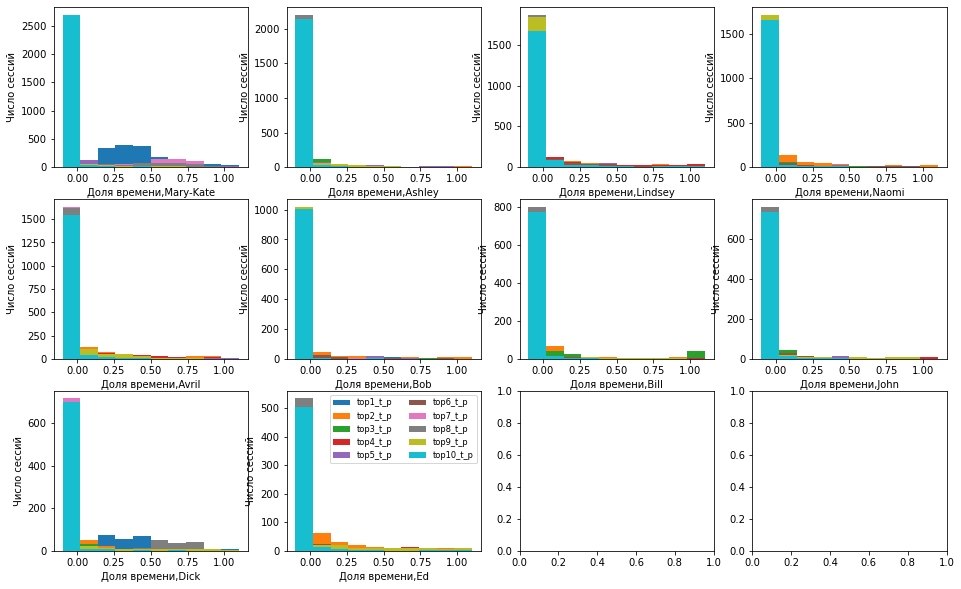

In [31]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

# как вариант, можно и по-другому
idx = 0
for key in id_name_dict.keys():
    name=id_name_dict[key]
    ax=axes.ravel()[idx]
    user_data = new_features_10users[new_features_10users.target == key]
    
    for i in range(1,11):
        ax.hist(user_data['top{}_t_p'.format(i)], histtype='bar',bins=10, range=(-0.1,1.1), 
                label='top{}_t_p'.format(i))
        ax.set_xlabel('Доля времени,{}'.format(name)) 
        ax.set_ylabel('Число сессий')
    idx+=1

ax.legend(loc='upper right', ncol = 2, fontsize = 'small')
plt.show()

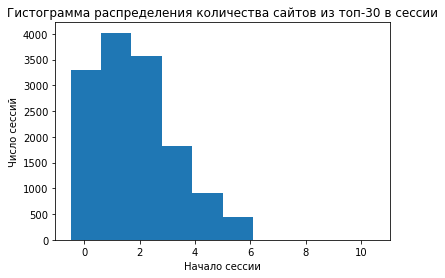

In [32]:
plt.title('Гистограмма распределения количества сайтов из топ-10 в сессии')
plt.xlabel('Число сайтов из топ-10 в сессии')
plt.ylabel('Число сессий')
plt.hist(new_features_10users['num_top30'], bins=10, range=(-0.5,10.5))
plt.show()

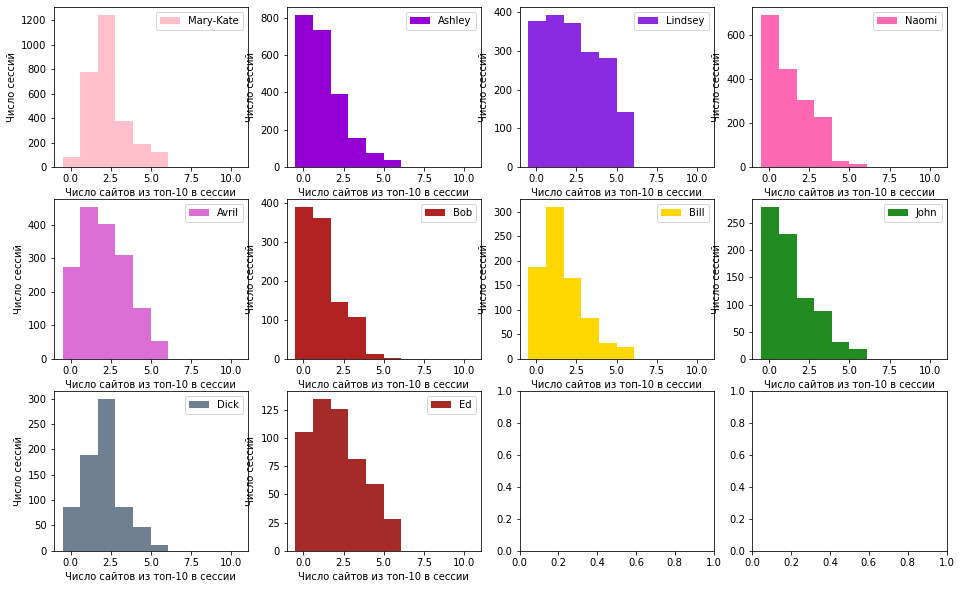

In [34]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

# как вариант, можно и по-другому
idx = 0
for key in id_name_dict.keys():
    name=id_name_dict[key]
    ax=axes.ravel()[idx]
    user_data = new_features_10users[new_features_10users.target == key]
    ax.set_xlabel('Число сайтов из топ-10 в сессии')
    ax.set_ylabel('Число сессий')
    ax.hist(user_data['num_top30'], bins=10, range=(-0.5,10.5), align='mid',label=name,color=color_dict[name])
    ax.legend(loc='best')
    idx+=1
plt.show()

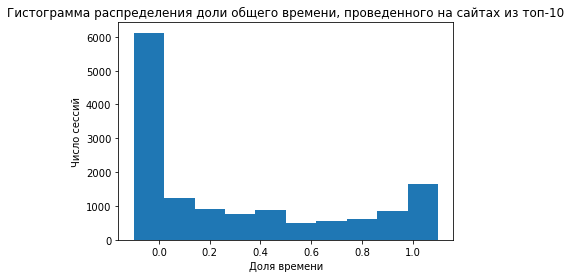

In [35]:
plt.title('Гистограмма распределения доли общего времени, проведенного на сайтах из топ-10')
plt.xlabel('Доля времени')
plt.ylabel('Число сессий')
plt.hist(new_features_10users['time_percent_top30'], bins=10, range=(-0.1,1.1))
plt.show()

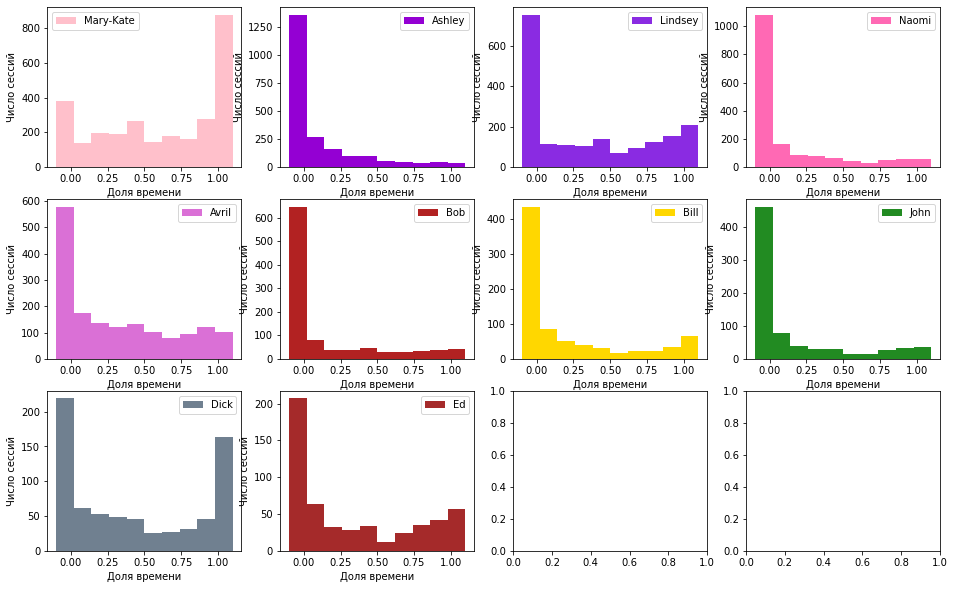

In [36]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

# как вариант, можно и по-другому
idx = 0
for key in id_name_dict.keys():
    name=id_name_dict[key]
    ax=axes.ravel()[idx]
    user_data = new_features_10users[new_features_10users.target == key]
    ax.set_xlabel('Доля времени')
    ax.set_ylabel('Число сессий')
    ax.hist(user_data['time_percent_top30'], bins=10, range=(-0.1,1.1), align='mid',label=name,color=color_dict[name])
    ax.legend(loc='best')
    idx+=1
plt.show()

**В конце сохраните в pickle-файлы только те признаки, которые, как Вы предполагаете, помогут идентифицировать пользователя более точно. Это касается и признаков, которые мы вместе создали в начале (*session_timespan, #unique_sites, start_hour, day_of_week*), и Ваших собственных. Можно создать все эти признаки не только для сессий из 10 сайтов, но и для других сочетаний параметров *session_length* и *window_size*.**

In [45]:
selected_features_10users = new_features_10users.loc[:,feature_names].drop(['site1', 'site2', 'site3', 'site4', 
                                                                            'site5','site6', 'site7', 'site8',
                                                                            'site9','site10','target'], axis = 1)
selected_features_150users = new_features_150users.loc[:,feature_names].drop(['site1', 'site2', 'site3', 'site4', 
                                                                            'site5','site6', 'site7', 'site8',
                                                                            'site9','site10','target'], axis = 1)

In [47]:
with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_10users.pkl'), 'wb') as selected_features_10users_pkl:
    pickle.dump(selected_features_10users, selected_features_10users_pkl, 
                protocol=2)
with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_150users.pkl'), 'wb') as selected_features_150users_pkl:
    pickle.dump(selected_features_150users, selected_features_150users_pkl, 
                protocol=2)

## Критерии оценки работы:
- Верно ли отображена гистограмма session_timespan из п. 1? (max. 3 балла)
- Верно ли отображена гистограмма #unique_sites из п. 2? (max. 3 балла)
- Верно ли отображены гистограммы #unique_sites по каждому пользователю из п. 3? (max. 6 баллов)
- Верно ли отображена гистограмма start_hour из п. 4? (max. 3 балла)
- Верно ли отображены гистограммы start_hour по каждому пользователю из п. 5? (max. 6 баллов)
- Верно ли отображена гистограмма day_of_week из п. 6? (max. 3 балла)
- Верно ли отображены гистограммы day_of_week по каждому пользователю из п. 7? (max. 6 баллов)
- Насколько сделанные выводы в п. 8 соответствуют построенным картинкам? (max. 6 баллов)
- Верно ли отображен barplot для 10 популярных сайтов из п. 9? (max. 6 баллов)
- Правильно ли посчитана медианная продолжительность сессий в п. 10? (max. 3 балла)
- Правильно ли посчитан медианный день недели начала сессии в п. 11? (max. 3 балла)
- Правильно ли посчитан медианный час начала сессии в п. 12? (max. 3 балла)
- Правильно ли посчитано медианное значение числа уникальных сайтов в сессиях 150 пользователей п. 13? (max. 3 балла)
- Есть ли оригинальные построенные признаки и картинки к ним? Оцените также и качество картинок. (max. 8 баллов)

## Пути улучшения
7 неделя посвящена общему описанию проекта (`html`, `ipynb` или `pdf`) и взаимному оцениванию. Что еще можно добавить по 3 части проекта:
- IPython-widgets, интерактив и анимация (стоящие статьи по этому ремеслу – [раз](https://habrahabr.ru/post/308162/) и  [два](https://habrahabr.ru/company/ods/blog/323210/))
- можно попробовать изобразить исходные данные в некотором пространстве, например, Word2Vec, потом выделить главные компоненты или t-SNE  (только пользуйтесь эффективными реализациями типа [Multicore-TSNE](https://github.com/DmitryUlyanov/Multicore-TSNE), не Sklearn) и раскрасить по целевому классу. Но нет гарантий, что получится что-то значимо отличающееся от каши

На следующей неделе мы наконец приступим к обучению моделей классификации. 